<a href="https://colab.research.google.com/github/AmiraBelkis/PFE-TEST/blob/optimize-WT/Cifar-10/AG_SimpleCNN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rssrc

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  6 18:23:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lib

In [16]:
import random
import string
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.colors as colors
import numpy as np
from copy import deepcopy

In [17]:
import AG

In [18]:
import importlib
import global_param
importlib.reload(global_param)
importlib.reload(AG)

Files already downloaded and verified
Files already downloaded and verified


<module 'AG' from '/content/AG.py'>

# AG

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-10/SimpleCNN_cifar_10'
model_base = torch.load(model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 60.49%
Loss: 1.1231


(0.6049, 1.12313185793579)

## Fine-tune the base model


---
in case model accurancy is low.


### Data augmentation

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import  CIFAR10

def load_cifar_10():
    # Define the data transformations
    data_transforms = {
        # use transforms.Compose to perform multiples transfomation at once
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
    }

    # Download and load the MNIST dataset
    train_dataset = CIFAR10(root='./data', train=True, transform=data_transforms['train'],download=True)
    test_dataset = CIFAR10(root='./data',  train=False, transform=data_transforms['val'],download=True)
    image_datasets ={
        'train':train_dataset,
        'val':test_dataset
    }
    # Create data loaders
    batch_size = 64
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
                        for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    return [dataloaders,dataset_sizes,class_names,device]


dataloaders,dataset_sizes,class_names,device = load_cifar_10()

Files already downloaded and verified
Files already downloaded and verified


### Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler , num_epochs=7):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    statics = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statics.append(
                {'epoch': epoch+1, 'phase': phase, 'acc': epoch_acc, 'loss': epoch_loss}
            )
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, statics

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(model_base.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
model , statics = train_model(model_base, criterion , optimizer_conv , exp_lr_scheduler , 10)

Epoch 0/9
----------
train Loss: 1.8149 Acc: 0.3398
val Loss: 1.4688 Acc: 0.4770

Epoch 1/9
----------
train Loss: 1.5677 Acc: 0.4323
val Loss: 1.3793 Acc: 0.5147

Epoch 2/9
----------
train Loss: 1.4952 Acc: 0.4622
val Loss: 1.3073 Acc: 0.5347

Epoch 3/9
----------
train Loss: 1.4393 Acc: 0.4847
val Loss: 1.2798 Acc: 0.5560

Epoch 4/9
----------
train Loss: 1.3777 Acc: 0.5084
val Loss: 1.2271 Acc: 0.5667

Epoch 5/9
----------
train Loss: 1.2313 Acc: 0.5595
val Loss: 1.0803 Acc: 0.6170

Epoch 6/9
----------
train Loss: 1.2014 Acc: 0.5715
val Loss: 1.0681 Acc: 0.6204

Epoch 7/9
----------
train Loss: 1.1821 Acc: 0.5792
val Loss: 1.0506 Acc: 0.6288

Epoch 8/9
----------
train Loss: 1.1709 Acc: 0.5836
val Loss: 1.0449 Acc: 0.6323

Epoch 9/9
----------
train Loss: 1.1588 Acc: 0.5841
val Loss: 1.0411 Acc: 0.6352

Training complete in 28m 51s
Best val Acc: 0.635200


In [ ]:
torch.save(model,model_path)

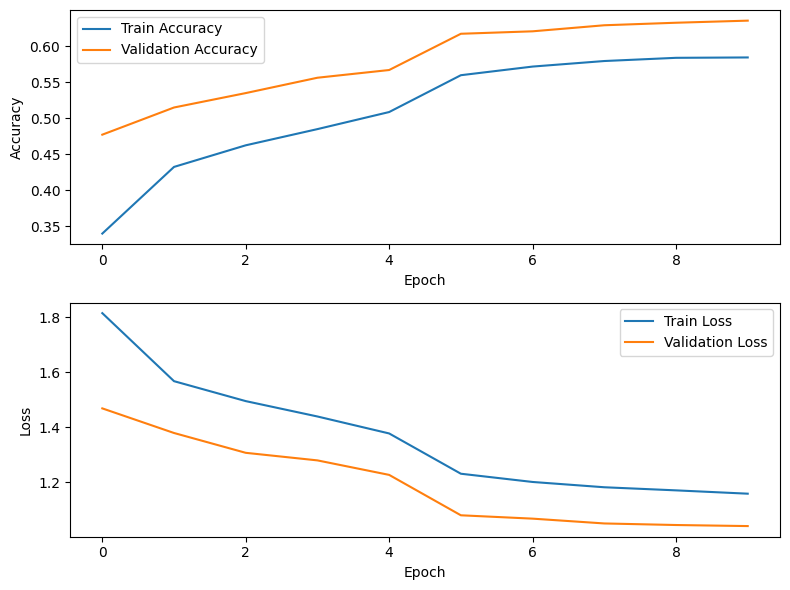

In [ ]:
AG.show_statics_training(statics, model_path + 'fine-tune -data augmentation- ' )

In [20]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 61.60%
Loss: 2.6351


(0.616, 2.6351336331883815)

## AG methode

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-10/SimpleCNN/'
os.makedirs(save_to, exist_ok=True)
os.makedirs(save_to +'children/', exist_ok=True)
os.makedirs(save_to +'parents/', exist_ok=True)
os.makedirs(save_to +'kd/', exist_ok=True)
os.makedirs(save_to +'kd/training/', exist_ok=True)

Generating the initial population :
     - individual 0 ----------- 100%
     - individual 1 ----------- 100%
     - individual 2 ----------- 100%
     - individual 3 ----------- 100%
     - individual 4 ----------- 100%
     - individual 5 ----------- 100%
     - individual 6 ----------- 100%
     - individual 7 ----------- 100%
Performing KD on the initial population :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 1.2009 Acc: 0.3754
val Loss: 0.9680 Acc: 0.4544

Epoch 1/4
----------
train Loss: 0.8952 Acc: 0.4713
val Loss: 0.8331 Acc: 0.4875

Epoch 2/4
----------
train Loss: 0.7911 Acc: 0.5099
val Loss: 0.8052 Acc: 0.4984

Epoch 3/4
----------
train Loss: 0.7238 Acc: 0.5419
val Loss: 0.7040 Acc: 0.5369

Epoch 4/4
----------
train Loss: 0.6668 Acc: 0.5672
val Loss: 0.6885 Acc: 0.5491

Training complete in 10m 52s
Best val Acc: 0.549100
------------------------------ Training 2 ---------------------------------
Epoch 0/4
--

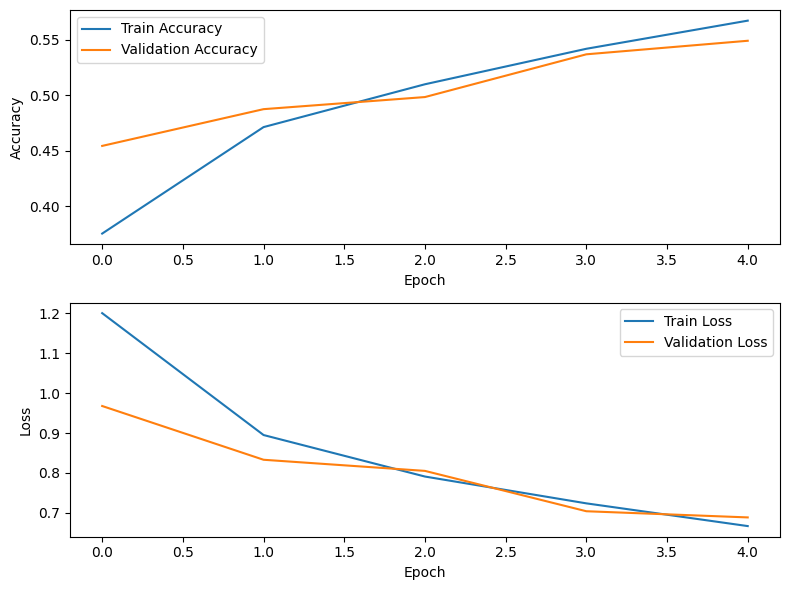

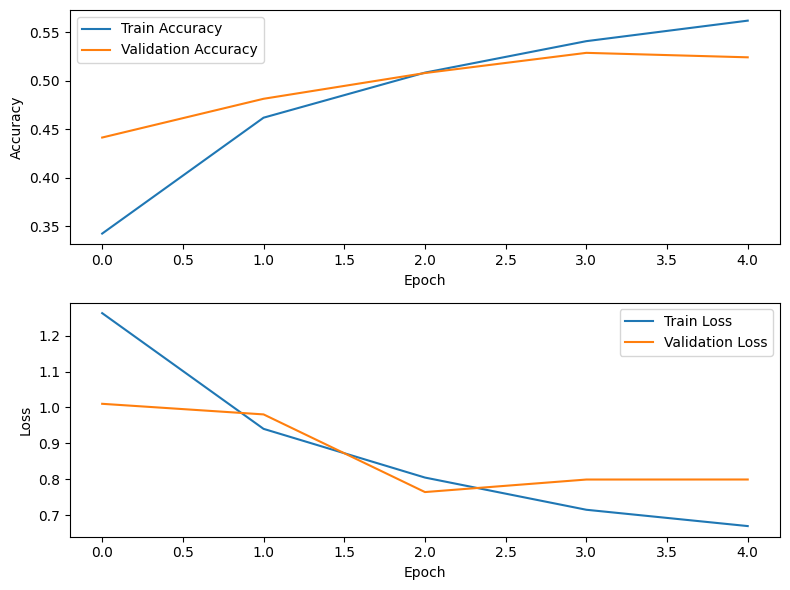

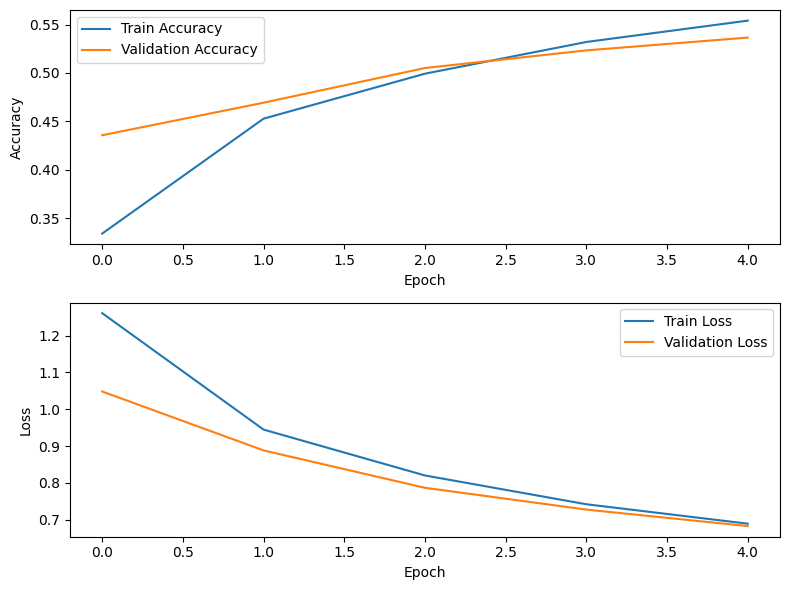

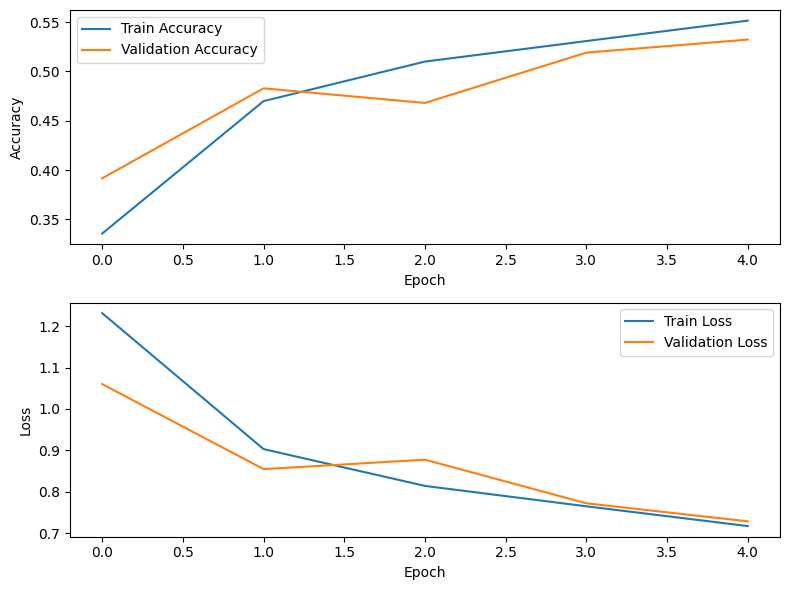

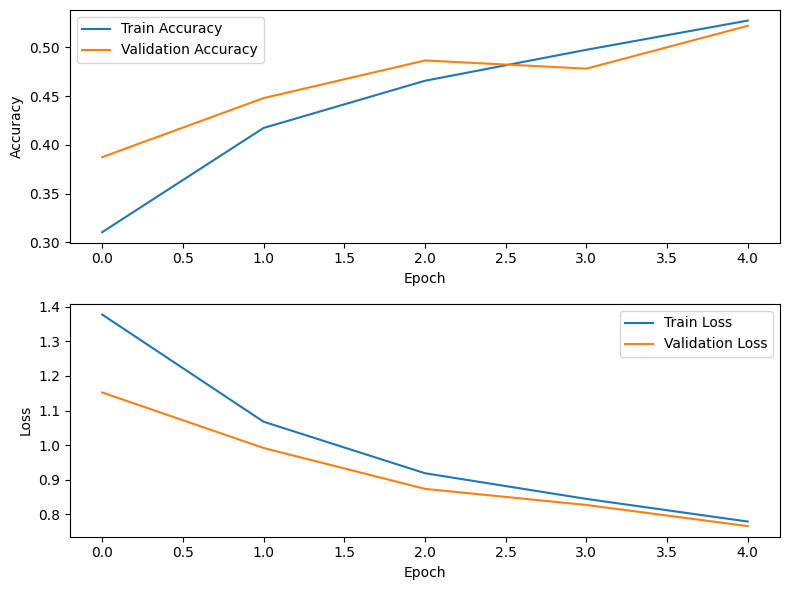

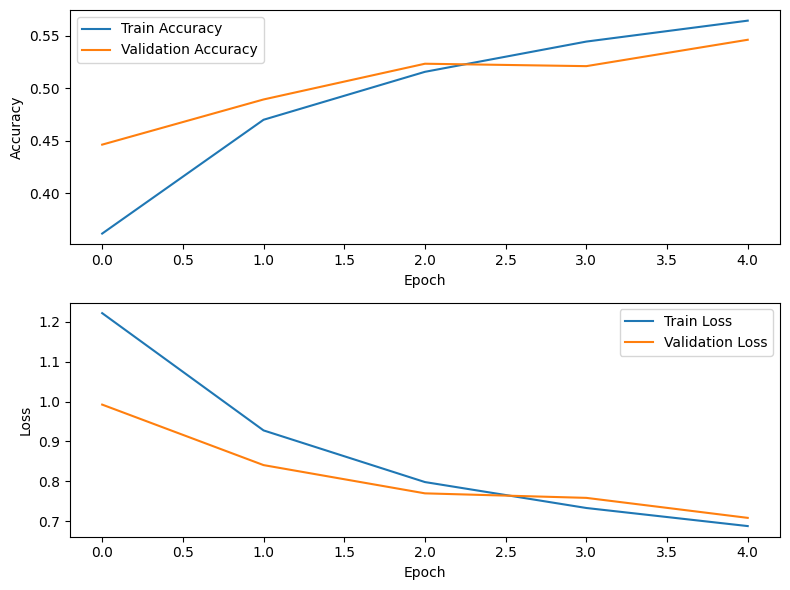

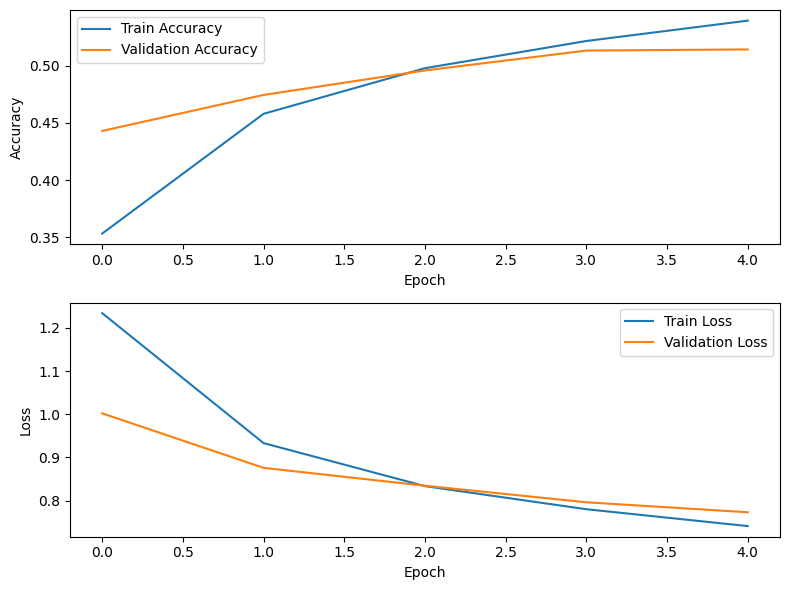

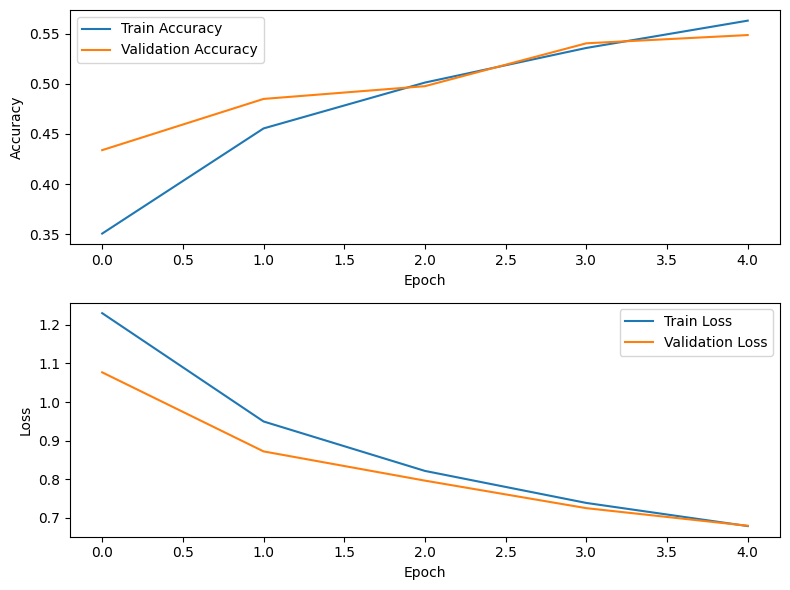

/*-----------------------------*/
/*         iteration 1        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 0, 1, 1]
       - Crossover:
           mask : [0, 1, 1, 0]
       - Performing KD on the children :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 0.9009 Acc: 0.4832
val Loss: 0.8117 Acc: 0.5087

Epoch 1/4
----------
train Loss: 0.7678 Acc: 0.5343
val Loss: 0.8123 Acc: 0.5126

Epoch 2/4
----------
train Loss: 0.7218 Acc: 0.5552
val Loss: 0.7279 Acc: 0.5334

Epoch 3/4
----------
train Loss: 0.6835 Acc: 0.5714
val Loss: 0.6980 Acc: 0.5570

Epoch 4/4
----------
train Loss: 0.6507 Acc: 0.5848
val Loss: 0.6755 Acc: 0.5517

Training complete in 10m 42s
Best val Acc: 0.557000
------------------------------ Training 2 ---------------------------------
Epoch 0/4
----------
train Loss: 0.8482 Acc: 0.4958
va

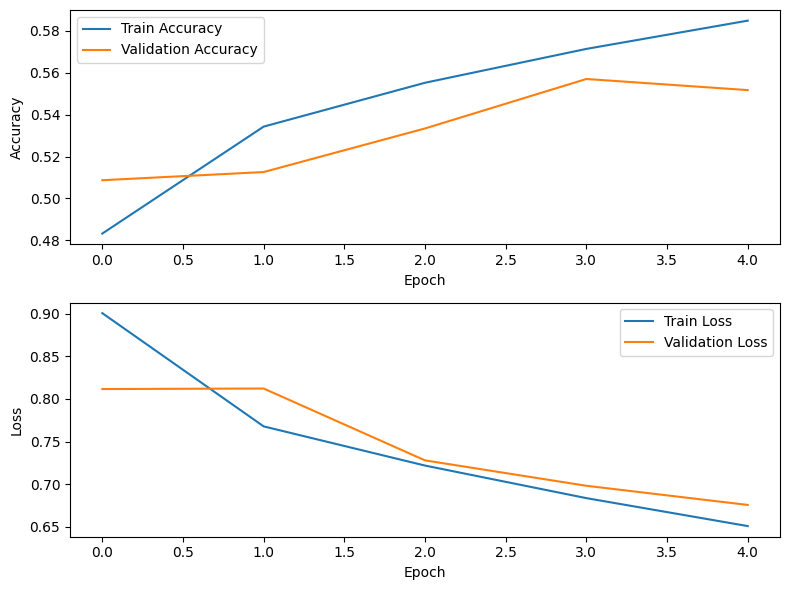

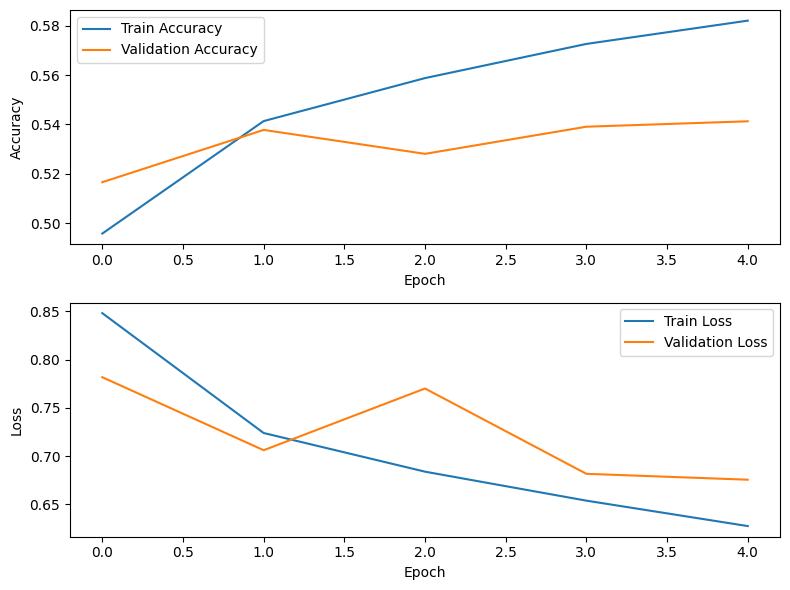

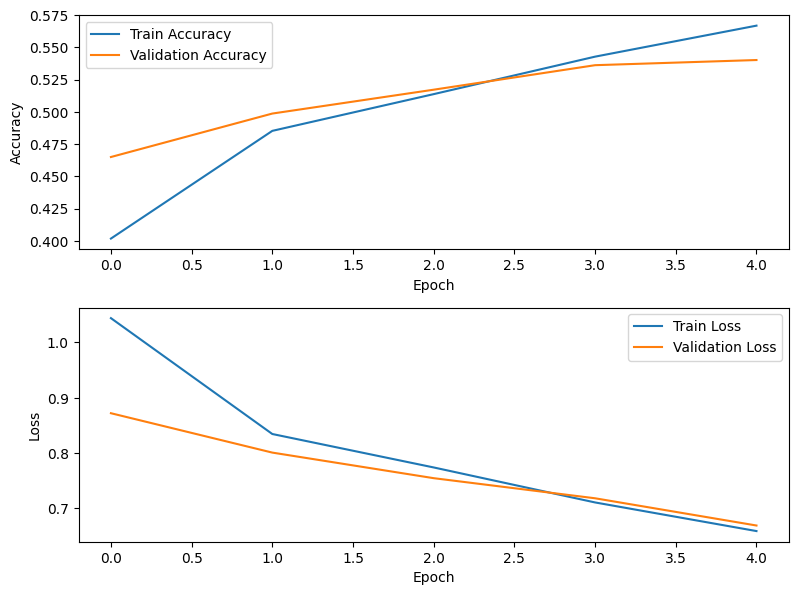

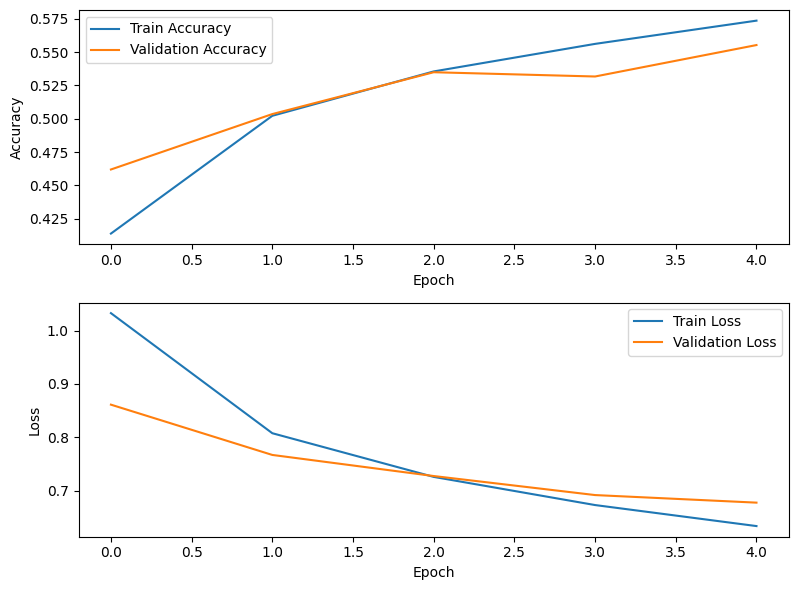

/*-----------------------------*/
/*         iteration 2        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 0, 0, 1]
       - Crossover:
           mask : [1, 0, 0, 0]
       - mutation:
       - Performing KD on the children :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 1.1424 Acc: 0.3962
val Loss: 0.9128 Acc: 0.4749

Epoch 1/4
----------
train Loss: 0.8300 Acc: 0.5008
val Loss: 0.7542 Acc: 0.5178

Epoch 2/4
----------
train Loss: 0.7434 Acc: 0.5351
val Loss: 0.7782 Acc: 0.5179

Epoch 3/4
----------
train Loss: 0.6955 Acc: 0.5563
val Loss: 0.7018 Acc: 0.5292

Epoch 4/4
----------
train Loss: 0.6672 Acc: 0.5712
val Loss: 0.6932 Acc: 0.5442

Training complete in 10m 40s
Best val Acc: 0.544200
------------------------------ Training 2 ---------------------------------
Epoch 0/4
----------
train Loss: 0.

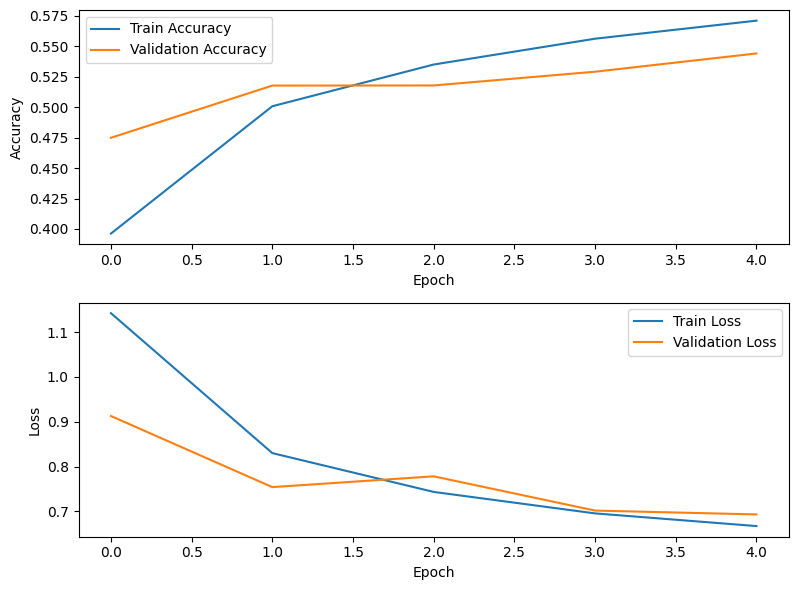

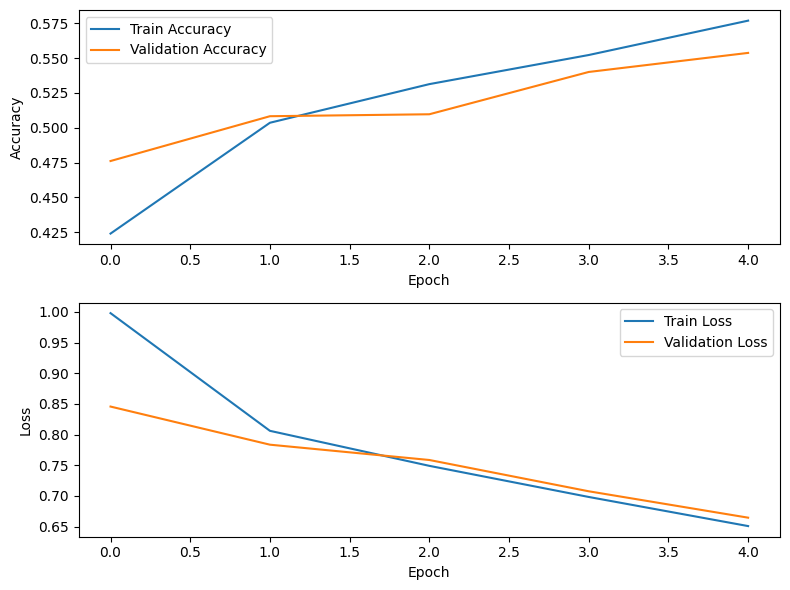

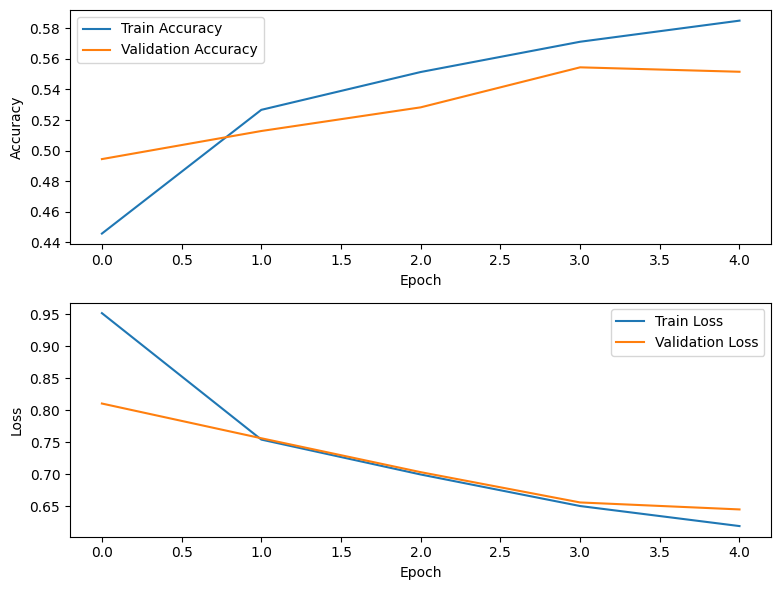

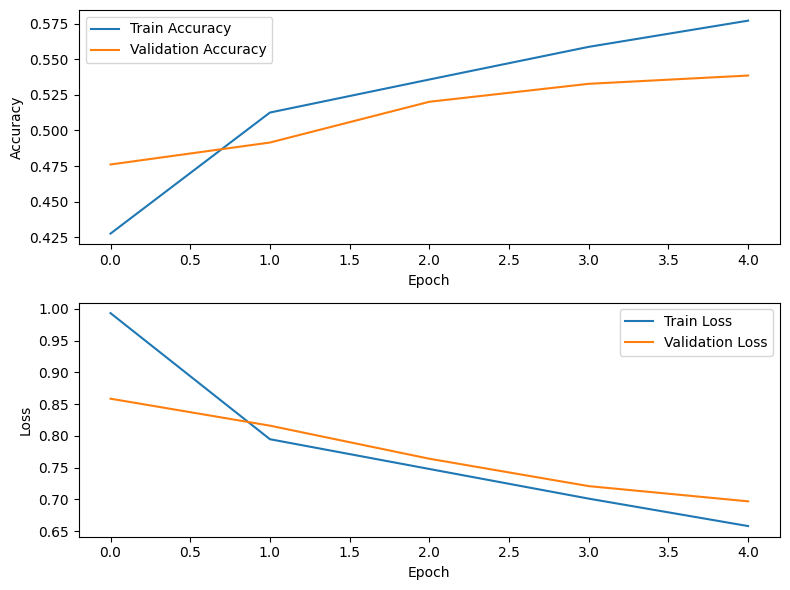

Select the winning ticket from final population
  - Selection --------------- 100%


In [ ]:
winning_ticket = AG.AG_method(model_base, save_to, nb_itr = 2, N = 8 ,pruning_rate = 0.85, pruning_space = 0.05,kd_epoch = 5)

## Evaluate the winning ticket

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-10/SimpleCNN/'
winning_ticket = torch.load( save_to + 'winning_ticket')

In [ ]:
AG.calculate_sparsity(winning_ticket)

tensor(0.8726, device='cuda:0')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 55.38%
Loss: 1.2628


(0.5538, 1.2627874749481298)

In [ ]:
data = AG.dataloaders['val']
for in_ , lbl in data:
  in_ = in_.to(AG.device)
  lbl = lbl.to(AG.device)
  out = winning_ticket(in_)
  _, preds = torch.max(out, 1)
  print(preds)
  print('-'*10)
  print(lbl)
  print('-'*10)
  print(preds-lbl)
  break

tensor([1, 1, 9, 8, 5, 0, 0, 7, 1, 9, 5, 6, 1, 4, 0, 3, 3, 0, 4, 1, 9, 5, 8, 8,
        9, 2, 5, 3, 1, 8, 0, 7, 5, 7, 3, 8, 3, 7, 1, 2, 6, 9, 1, 3, 6, 1, 7, 5,
        3, 7, 9, 4, 0, 7, 8, 9, 6, 5, 5, 5, 3, 6, 4, 3], device='cuda:0')
----------
tensor([1, 1, 1, 8, 3, 4, 0, 7, 1, 9, 5, 2, 8, 2, 0, 2, 2, 0, 4, 1, 7, 5, 5, 8,
        9, 2, 3, 5, 9, 8, 0, 2, 3, 4, 7, 8, 5, 7, 1, 4, 4, 1, 8, 3, 5, 1, 7, 3,
        0, 4, 7, 4, 4, 7, 0, 1, 5, 7, 6, 0, 5, 6, 4, 7], device='cuda:0')
----------
tensor([ 0,  0,  8,  0,  2, -4,  0,  0,  0,  0,  0,  4, -7,  2,  0,  1,  1,  0,
         0,  0,  2,  0,  3,  0,  0,  0,  2, -2, -8,  0,  0,  5,  2,  3, -4,  0,
        -2,  0,  0, -2,  2,  8, -7,  0,  1,  0,  0,  2,  3,  3,  2,  0, -4,  0,
         8,  8,  1, -2, -1,  5, -2,  0,  0, -4], device='cuda:0')


## Fine tuning the winning ticket

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(winning_ticket.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
winning_ticket , statics = train_model(winning_ticket, criterion , optimizer_conv , exp_lr_scheduler , 20)

Epoch 0/19
----------
train Loss: 1.3359 Acc: 0.5262
val Loss: 1.2085 Acc: 0.5666

Epoch 1/19
----------
train Loss: 1.3279 Acc: 0.5279
val Loss: 1.1979 Acc: 0.5714

Epoch 2/19
----------
train Loss: 1.3213 Acc: 0.5263
val Loss: 1.2042 Acc: 0.5716

Epoch 3/19
----------
train Loss: 1.3162 Acc: 0.5307
val Loss: 1.2220 Acc: 0.5615

Epoch 4/19
----------
train Loss: 1.3141 Acc: 0.5300
val Loss: 1.2071 Acc: 0.5710

Epoch 5/19
----------
train Loss: 1.3077 Acc: 0.5342
val Loss: 1.1800 Acc: 0.5790

Epoch 6/19
----------
train Loss: 1.3086 Acc: 0.5322
val Loss: 1.1949 Acc: 0.5767

Epoch 7/19
----------
train Loss: 1.2931 Acc: 0.5386
val Loss: 1.1849 Acc: 0.5784

Epoch 8/19
----------
train Loss: 1.2940 Acc: 0.5391
val Loss: 1.1882 Acc: 0.5782

Epoch 9/19
----------
train Loss: 1.2887 Acc: 0.5421
val Loss: 1.1881 Acc: 0.5767

Epoch 10/19
----------
train Loss: 1.2926 Acc: 0.5389
val Loss: 1.1877 Acc: 0.5767

Epoch 11/19
----------
train Loss: 1.2896 Acc: 0.5396
val Loss: 1.1860 Acc: 0.5779

Ep

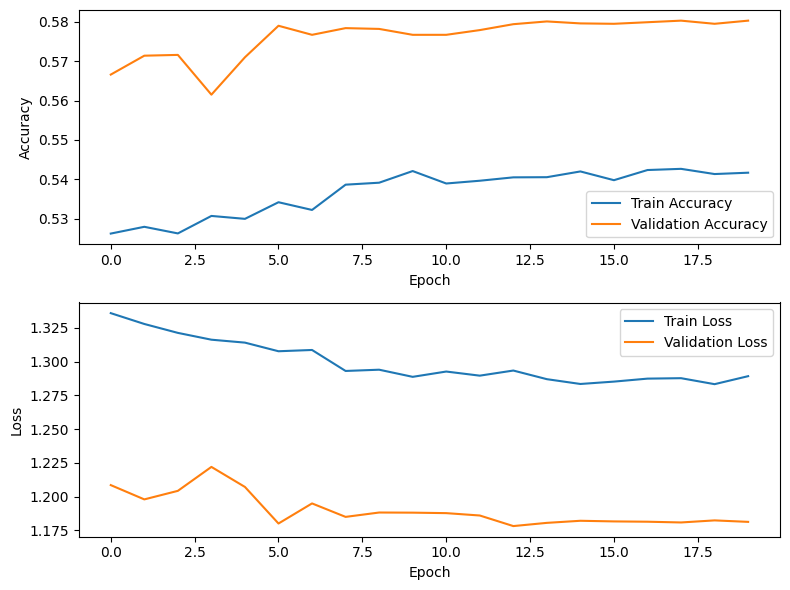

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-10/SimpleCNN/'
AG.show_statics_training(statics, save_to + 'winning_ticket fine tuning_')
torch.save(winning_ticket, save_to + 'winning_ticket_')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 56.08%
Loss: 1.2631


(0.5608, 1.2630762066810755)

## Perform KD for extra epochs

use resnet to finetune the wt

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-10/resnet18_cifar_10'
model_base = torch.load(model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 95.13%
Loss: 0.1590


(0.9513, 0.1589713708444196)

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-10/SimpleCNN/'
winning_ticket = torch.load( save_to + 'winning_ticket')

------------------------------ Training ---------------------------------
Epoch 0/14
----------
train Loss: 2.1636 Acc: 0.5903
val Loss: 2.1028 Acc: 0.5854

Epoch 1/14
----------
train Loss: 2.0543 Acc: 0.6116
val Loss: 2.0376 Acc: 0.5953

Epoch 2/14
----------
train Loss: 1.9875 Acc: 0.6296
val Loss: 2.0372 Acc: 0.5946

Epoch 3/14
----------
train Loss: 1.9346 Acc: 0.6489
val Loss: 2.0101 Acc: 0.6008

Epoch 4/14
----------
train Loss: 1.8847 Acc: 0.6644
val Loss: 2.0087 Acc: 0.6002

Epoch 5/14
----------
train Loss: 1.8398 Acc: 0.6832
val Loss: 1.9986 Acc: 0.6105

Epoch 6/14
----------
train Loss: 1.7962 Acc: 0.6992
val Loss: 1.9944 Acc: 0.6123

Epoch 7/14
----------
train Loss: 1.7557 Acc: 0.7131
val Loss: 2.0198 Acc: 0.5994

Epoch 8/14
----------
train Loss: 1.7146 Acc: 0.7283
val Loss: 2.0120 Acc: 0.6014

Epoch 9/14
----------
train Loss: 1.6209 Acc: 0.7644
val Loss: 1.9963 Acc: 0.6143

Epoch 10/14
----------
train Loss: 1.5898 Acc: 0.7743
val Loss: 2.0148 Acc: 0.6102

Epoch 11/14


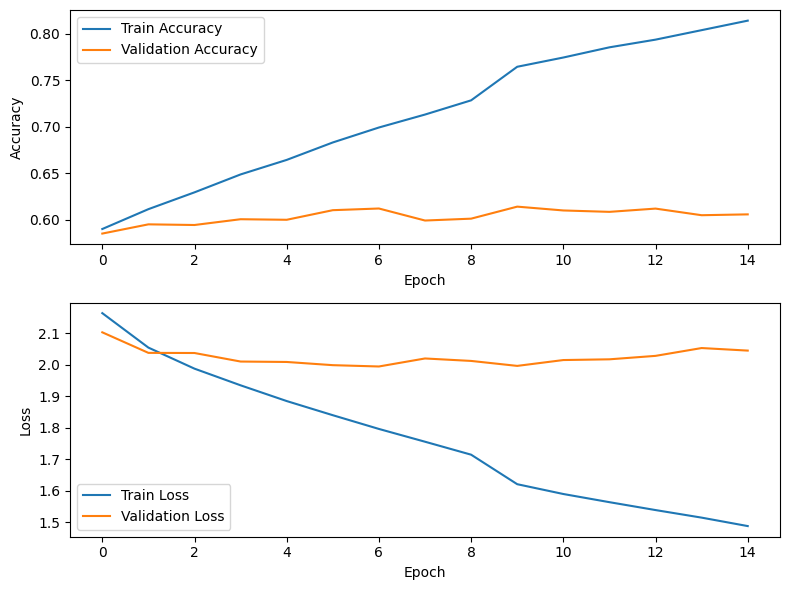

In [ ]:
criterion = AG.SoftHardTargetLoss(global_param.soft_citerion,global_param.hard_citerion, global_param.soft_purcntg, global_param.hard_purcntg)

optimizer_conv =  optim.SGD(winning_ticket.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler =  lr_scheduler.StepLR(optimizer_conv, step_size=9, gamma=0.5)

print("------------------------------ Training ---------------------------------")
# Train the model
winning_ticket, statics = AG.train_model_kd_mix(winning_ticket,model_base, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=15)
AG.show_statics_training(statics, save_to + 'winning_ticket')
torch.save(winning_ticket, save_to + 'winning_ticket')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 61.43%
Loss: 1.5118


(0.6143, 1.5117717294176674)